In [1]:
# Cell 0 — Imports & GLOBAL CONSTANTS
from pathlib import Path
import os, json, random, math, itertools
import numpy as np
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
from copy import deepcopy
import os, time, matplotlib.pyplot as plt

# ───── Reproducibility ───────────────────────────────────────────
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───── Paths ─────────────────────────────────────────────────────
ROOT_DIR        = Path('.')                # project root
DESC_JSON       = ROOT_DIR / 'description.json'
DATASET_ROOT    = ROOT_DIR / 'dataset'     # train images
Zero_TEST_ROOT       = ROOT_DIR / 'testFolder'     # test for zero shot images
Few_TEST_ROOT       = ROOT_DIR / 'fewShot'     # test for few shot images
CKPT_PATH       = ROOT_DIR / 'medCLIP_runs_three2One' / 'best‑epoch06.pth'
SIM_MATRIX_PATH = ROOT_DIR / 'phrase_cosine_sim.npy'
SAVE_DIR        = ROOT_DIR / 'medCLIP_runs_three2One'
# ───── Text‑embedding model & phrase rules ───────────────────────
EMBED_MODEL_NAME = 'pritamdeka/S-PubMedBert-MS-MARCO'
PHRASE_SLICES = {                 
    'visual'  : slice(0, 5),
    'clinical': slice(5, 8),
    'public'  : slice(8, 10),
}


/home/ammar/anaconda3/envs/mariam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 1 — Load description.json
assert DESC_JSON.exists(), f'Missing {DESC_JSON}'
with DESC_JSON.open(encoding='utf-8') as f:
    raw_desc = json.load(f)

print(f'Loaded {len(raw_desc)} diseases | '
      f'{sum(len(v) for v in raw_desc.values())} total phrases')


Loaded 40 diseases | 400 total phrases


In [3]:
from transformers import AutoTokenizer

all_phrases = [p.strip() for plist in raw_desc.values() for p in plist]


# ── Tokenization analysis ─────────────────────────────
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

lengths = [len(tokenizer(p)["input_ids"]) for p in all_phrases]

print(f"Max token length:       {max(lengths)}")
print(f"95th percentile length: {np.percentile(lengths, 95):.1f}")
print(f"99th percentile length: {np.percentile(lengths, 99):.1f}")


Max token length:       90
95th percentile length: 78.0
99th percentile length: 83.0


In [ ]:
# Cell 2 — Compute phrase uniqueness + full similarity matrix
records, owners = [], []
for disease, plist in raw_desc.items():
    for p in plist:
        owners.append(disease.lower())
        records.append(p.strip())

owners_np  = np.array(owners)
unique_d   = sorted(set(owners_np))
phrase_to_id = {(owners[i], records[i]): i for i in range(len(records))}

# ── Sentence‑BERT embeddings ──────────────────────────────────────
embedder = SentenceTransformer(EMBED_MODEL_NAME, device=DEVICE)
with torch.no_grad():
    embs = embedder.encode(records,
                           batch_size=8,
                           convert_to_tensor=True,
                           normalize_embeddings=True)  # (N,D)

# save full cosine matrix
S_full = (embs @ embs.T).cpu().numpy().astype('float32')
np.save(SIM_MATRIX_PATH, S_full)
del S_full                                 # free memory

# ── Uniqueness weight (1 − max sim to other diseases) ─────────────
phrase_weight = {}
for d in tqdm(unique_d, desc='weights'):
    idx_this  = np.where(owners_np == d)[0]
    idx_other = np.where(owners_np != d)[0]
    if idx_other.size == 0:                       # orphan disease
        for i in idx_this: phrase_weight[(d, records[i])] = 1.0
        continue
    sim = (embs[idx_this] @ embs[idx_other].T).max(1).values
    for ii, s in zip(idx_this, sim):
        phrase_weight[(d, records[ii])] = 1.0 - float(s)

print('uniqueness weights & sim matrix saved ->', SIM_MATRIX_PATH)


weights: 100%|██████████| 40/40 [00:00<00:00, 946.23it/s]

uniqueness weights & sim matrix saved → phrase_cosine_sim.npy


In [ ]:
# Cell 3 — Utility: sample three phrases using the 5/3/2 rule
def sample_three_phrases(disease: str):

    plist = raw_desc[disease][:]                  
    assert len(plist) >= 10, f'{disease} needs ≥10 phrases'

    chosen = [
        random.choice(plist[PHRASE_SLICES['visual']]),
        random.choice(plist[PHRASE_SLICES['clinical']]),
        random.choice(plist[PHRASE_SLICES['public']]),
    ]
    ids = [phrase_to_id[(disease.lower(), p.strip())] for p in chosen]
    w   = np.mean([phrase_weight[(disease.lower(), p.strip())] for p in chosen])
    return chosen, ids, float(w)


In [8]:
# Cell 4 — Gather image–phrase pairs
IMG_ROOT = DATASET_ROOT
assert IMG_ROOT.is_dir(), f'Missing {IMG_ROOT}'

disease_to_id = {d.lower(): i for i, d in enumerate(sorted(raw_desc))}
pairs = []   # (img_path, phrases, phrase_ids, class_id, weight)

for d in sorted(raw_desc):
    d_path = IMG_ROOT / d
    if not d_path.exists():
        print(f' {d_path} not found; skipping disease')
        continue
    imgs = sorted(p for p in d_path.iterdir()
                  if p.suffix.lower() in {'.jpg', '.png'})
    for img in imgs:
        phrases, ids, w = sample_three_phrases(d)
        pairs.append((img, phrases, ids, disease_to_id[d.lower()], w))

print(f'Built {len(pairs)} image–caption pairs with weights')


 dataset/Acute Cerebellitis in HIV not found; skipping disease
 dataset/Acute Unilateral Cerebellitis in HIV not found; skipping disease
 dataset/Fukuyama Muscular Dystrophy not found; skipping disease
 dataset/Inferior Vena Cava (IVC) Leiomyosarcoma-20240916T165709Z-001 not found; skipping disease
 dataset/Low Medial Insertion of Common Bile Duct with Pancreas Divisum-20240916T165825Z-001 not found; skipping disease
 dataset/Magnetic Resonance (MR) Spine not found; skipping disease
 dataset/Pigmented Villonodular Synovitis (PVNS) of Ankle not found; skipping disease
 dataset/Thoracic Outlet Syndrome not found; skipping disease
Built 17018 image–caption pairs with weights


In [24]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

sampled_phrases = [p for (_, phrases, _, _, _) in pairs for p in phrases]

lengths = [len(tokenizer(p)["input_ids"]) for p in sampled_phrases]

print(f"Analyzed {len(sampled_phrases)} sampled phrases (3 per image)")
print(f"Max token length:       {max(lengths)}")
print(f"95th percentile length: {np.percentile(lengths, 95):.1f}")
print(f"99th percentile length: {np.percentile(lengths, 99):.1f}")


Analyzed 51054 sampled phrases (3 per image)
Max token length:       83
95th percentile length: 75.0
99th percentile length: 80.0


In [21]:
# Cell 5 — Print names of sub‑directories in dataset (with >8 images only)
from pathlib import Path
import os


def list_dirs(root):
    return sorted([p.name for p in root.iterdir() if p.is_dir()]) if root.exists() else f'[Missing] {root}'

def count_files_in_dir(dir_path):
    return len([f for f in dir_path.iterdir() if f.is_file()])

# Filter only diseases with more than 8 files
diseases = [
    d for d in list_dirs(DATASET_ROOT)
    if count_files_in_dir(DATASET_ROOT / d) > 8
]

# Print every 5 diseases
for i, disease in enumerate(diseases, 1):
    print('dataset:', disease)

print('\nTotal diseases with > 8 files:', len(diseases))


dataset: Balloon Cell Cortical Dysplasia
dataset: Carolis Disease
dataset: Congenital Toxoplasmosis
dataset: Dermatomyositis
dataset: Gamekeepers Thumb
dataset: Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis
dataset: Japanese B Encephalitis or Epstein-Barr Encephalitis
dataset: Leighs Disease in Spinal Cord and Inferior Colliculi
dataset: Lumbosacral Plexitis
dataset: Moyamoya Disease with Intraventricular Hemorrhage
dataset: Myositis Ossificans Progressiva
dataset: Neurofibromatosis Type 1 (NF1) with Optic Glioma and Intracranial Extension
dataset: Optic Glioma
dataset: Osmotic Demyelination Syndrome
dataset: Pachygyria with Cerebellar Hypoplasia
dataset: Perisylvian Syndrome
dataset: Plexiform Neurofibroma with Sphenoid Wing Absence
dataset: Rasmussens Encephalitis
dataset: Retinoblastoma with Intracranial Spread Along Cranial Nerve
dataset: Right Brachial Plexitis
dataset: Sjögrens Syndrome
dataset: Tuberous Sclerosis
dataset: Typical Adrenoleukodystrophy
datas

In [22]:
# Cell 5 — Print names of sub‑directories in dataset (with >8 images only)
from pathlib import Path
import os


def list_dirs(root):
    return sorted([p.name for p in root.iterdir() if p.is_dir()]) if root.exists() else f'[Missing] {root}'

def count_files_in_dir(dir_path):
    return len([f for f in dir_path.iterdir() if f.is_file()])

# Filter only diseases with more than 8 files
diseases = [
    d for d in list_dirs(DATASET_ROOT)
    if count_files_in_dir(DATASET_ROOT / d) < 8
]

# Print every 5 diseases
for i, disease in enumerate(diseases, 1):
    print('dataset:', disease)


print('\nTotal diseases with < 8 files:', len(diseases))


dataset: Adenomyosis in Gravid Uterus
dataset: Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis
dataset: Bilateral Ulnar Impaction Syndrome
dataset: Congenital Vaginal Cyst
dataset: Hallervorden-Spatz Disease (now called Pantothenate Kinase-Associated Neurodegeneration)
dataset: Magnetic Resonance (MR) Brain
dataset: Sural Nerve Neurofibroma
dataset: Two-Week Follow-Up with Spectroscopy

Total diseases with < 8 files: 8


In [16]:
# Cell 5 — Print names of sub‑directories in testFolder, fewShot
from pathlib import Path
import os

ROOT_DIR = Path('.')
ZERO_TEST_ROOT = ROOT_DIR / 'testFolder'
FEW_TEST_ROOT  = ROOT_DIR / 'fewShot'

def list_dirs(root):
    return sorted([p.name for p in root.iterdir() if p.is_dir()]) if root.exists() else f'[Missing] {root}'

for disease in list_dirs(ZERO_TEST_ROOT):
    print('testFolder:', disease)
print ("-----------------------------------")
for disease in list_dirs(FEW_TEST_ROOT):
    print('fewShot:', disease)


testFolder: Acute Cerebellitis in HIV
testFolder: Acute Unilateral Cerebellitis in HIV
testFolder: Fukuyama Muscular Dystrophy
testFolder: Inferior Vena Cava (IVC) Leiomyosarcoma-20240916T165709Z-001
testFolder: Low Medial Insertion of Common Bile Duct with Pancreas Divisum-20240916T165825Z-001
testFolder: Magnetic Resonance (MR) Spine
testFolder: Pigmented Villonodular Synovitis (PVNS) of Ankle
testFolder: Thoracic Outlet Syndrome
-----------------------------------
fewShot: Adenomyosis in Gravid Uterus
fewShot: Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis
fewShot: Bilateral Ulnar Impaction Syndrome
fewShot: Congenital Vaginal Cyst
fewShot: Hallervorden-Spatz Disease (now called Pantothenate Kinase-Associated Neurodegeneration)
fewShot: Magnetic Resonance (MR) Brain
fewShot: Sural Nerve Neurofibroma
fewShot: Two-Week Follow-Up with Spectroscopy


In [9]:
# Cell 6 — Tokenizer + image transforms
from transformers import AutoTokenizer
from torchvision import transforms

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                          model_max_length=128)

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])


In [10]:
# Cell 7 — Dataset definition
class WeightedMedClipDiseaseDataset(Dataset):
    def __init__(self, items, tokenizer, transform, max_len=128):
        self.items  = items
        self.tok    = tokenizer
        self.trf    = transform
        self.maxlen = max_len

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, phrases, ids, cid, w = self.items[idx]

        enc = self.tok(phrases,
                       padding="max_length",
                       truncation=True,
                       max_length=self.maxlen,
                       return_tensors="pt")

        img = self.trf(Image.open(img_path).convert("RGB"))

        return {
            "image"          : img,                 # (3,224,224)
            "input_ids"      : enc["input_ids"],    # (3,L)
            "attention_mask" : enc["attention_mask"],
            "phrase_ids"     : torch.tensor(ids, dtype=torch.long),
            "weight"         : torch.tensor(w, dtype=torch.float32),
            "class_id"       : cid,
        }


In [11]:
# Cell 8 — Train / val split
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    range(len(pairs)),
    test_size=0.2,
    stratify=[p[3] for p in pairs],   # stratify by class_id
    random_state=SEED,
)

print(f"Train set : {len(train_idx)} images")
print(f"Val set   : {len(val_idx)} images")


Train set : 13614 images
Val set   : 3404 images


In [ ]:
# Cell 9 — Create Dataset objects
dataset_full = WeightedMedClipDiseaseDataset(pairs, tokenizer, image_transform)

train_ds = torch.utils.data.Subset(dataset_full, train_idx)
val_ds   = torch.utils.data.Subset(dataset_full, val_idx)


In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2,
                          pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2,
                          pin_memory=torch.cuda.is_available())

batch = next(iter(train_loader))
print("image tensor      :", batch['image'].shape)
print("input_ids         :", batch['input_ids'].shape)
print("attention_mask    :", batch['attention_mask'].shape)
print("phrase_ids        :", batch['phrase_ids'].shape)
print("weight tensor     :", batch['weight'].shape)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


image tensor      : torch.Size([8, 3, 224, 224])
input_ids         : torch.Size([8, 3, 128])
attention_mask    : torch.Size([8, 3, 128])
phrase_ids        : torch.Size([8, 3])
weight tensor     : torch.Size([8])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
# Cell 11 — Helper: show a single (image, phrases) pair
from IPython.display import display as show, Markdown

def show_pair(idx: int):
    """
    Visualise one entry from the `pairs` list.
    """
    img_path, phrases, phrase_ids, class_id, w = pairs[idx]
    disease = [k for k, v in disease_to_id.items() if v == class_id][0]

    show(Markdown(f"### {idx} • **{disease}**  (weight {w:.3f})"))
    show(Image.open(img_path))
    for s in phrases:
        show(Markdown(f"* {s}"))


### 0 • **adenomyosis in gravid uterus**  (weight 0.059)

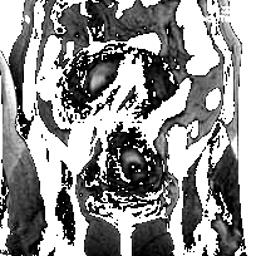

* Coronal and sagittal T2-weighted images demonstrate a heterogeneously hypointense thickened junctional zone with multiple small hyperintense cystic spaces. These lesions exhibit indistinct borders and lack capsular definition, reinforcing the diagnosis of diffuse adenomyosis during pregnancy.

* The adenomyotic involvement is dominantly posterior and fundal in distribution, with asymmetric thickening and multiple cystic foci disrupting the normal junctional zone. The anterior wall remains relatively spared, producing a classic posterior-dominant pattern.

* Adenomyosis in a gravid uterus remains classified under benign myometrial proliferative disorders. MRI distinguishes it from leiomyomas by the presence of multiple small hyperintense foci, junctional zone thickening, and poor circumscription.

### 1 • **adenomyosis in gravid uterus**  (weight 0.054)

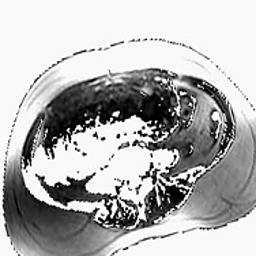

* An MRI sagittal image reveals a globally enlarged uterus with focal posterior wall thickening. The junctional zone appears disrupted and replaced by multiple T2 hyperintense cystic foci of variable size. The appearance is characteristic of focal adenomyosis, now more pronounced due to gestational uterine expansion.

* Imaging suggests that adenomyotic foci are embedded within the inner to mid-myometrial zones, presenting bilaterally but with a clear posterior predominance. The distribution is consistent across multiple planes, with no apparent displacement of surrounding organs.

* Adenomyosis in a gravid uterus remains classified under benign myometrial proliferative disorders. MRI distinguishes it from leiomyomas by the presence of multiple small hyperintense foci, junctional zone thickening, and poor circumscription.

In [15]:
# Cell 12 — Display first pair
show_pair(0)
show_pair(1)

In [ ]:
# Cell 13 — MedCLIPCustom definition

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import numpy as np
import timm

class BioClinicalBERTEncoder(nn.Module):
    """
    Handles both (B, K, L) and (B*K, L) token tensors.
    If (B, K, L) → averages over K captions → (B, D)
    If (B*K, L)  → returns one embedding per caption → (B*K, D)
    """
    def __init__(self, proj_dim=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        # freeze backbone
        for p in self.bert.parameters():
            p.requires_grad = False
        self.bert.eval()

        self.proj = nn.Linear(self.bert.config.hidden_size, proj_dim)

    @torch.no_grad()
    def _encode_bert(self, input_ids, attention_mask):
        return self.bert(input_ids=input_ids,
                         attention_mask=attention_mask).last_hidden_state[:, 0]

    def forward(self, input_ids, attention_mask):
        if input_ids.dim() == 3:                  # (B, K, L)
            B, K, L = input_ids.shape
            ids  = input_ids.view(-1, L)          # (B*K, L)
            mask = attention_mask.view(-1, L)
            cls  = self._encode_bert(ids, mask)   # (B*K, H)
            cls  = self.proj(cls)                 # (B*K, D)
            cls  = F.normalize(cls, p=2, dim=-1)
            cls  = cls.view(B, K, -1).mean(1)     # (B, D)
            return F.normalize(cls, p=2, dim=-1)

        elif input_ids.dim() == 2:                # (B*K, L)
            cls = self._encode_bert(input_ids, attention_mask)  # (B*K, H)
            cls = self.proj(cls)                                   # (B*K, D)
            return F.normalize(cls, p=2, dim=-1)

        else:
            raise ValueError("input_ids must be 2D or 3D (got shape {})."
                             .format(tuple(input_ids.shape)))


class SwinEncoder(nn.Module):
    def __init__(self, model_name="swin_base_patch4_window7_224", proj_dim=256):
        super().__init__()
        self.model = timm.create_model(model_name,
                                       pretrained=True,
                                       num_classes=0,
                                       global_pool="avg")
        self.proj = nn.Linear(self.model.num_features, proj_dim)

    def forward(self, x):
        feat = self.model(x)
        feat = self.proj(feat)
        return F.normalize(feat, p=2, dim=-1)


class MedCLIPCustom(nn.Module):
    def __init__(self, proj_dim=256):
        super().__init__()
        self.vision_encoder = SwinEncoder(proj_dim=proj_dim)
        self.text_encoder   = BioClinicalBERTEncoder(proj_dim=proj_dim)
        self.logit_scale    = nn.Parameter(torch.ones([]) * np.log(1/0.07))

    def forward(self, images, input_ids, attention_mask):
        img_feat = self.vision_encoder(images)                  # (B or B*K, D)
        txt_feat = self.text_encoder(input_ids, attention_mask) # (B or B*K, D)
        return img_feat, txt_feat


In [35]:
# Cell 14 — Count trainable vs. frozen params

model = MedCLIPCustom(proj_dim=256).to(DEVICE).eval()

def count_params(net):
    total = sum(p.numel() for p in net.parameters())
    train = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return total, train

tot, train = count_params(model)
print(f'Total parameters    : {tot/1e6:.1f} M')
print(f'Trainable parameters: {train/1e6:.1f} M')


Total parameters    : 195.5 M
Trainable parameters: 87.2 M


In [17]:
# %% Cell 11 — Weighted InfoNCE loss
def weighted_info_nce(
    img_emb: torch.Tensor,          # (B, D)
    txt_emb: torch.Tensor,          # (B, D)
    txt_ids: torch.Tensor,          # (B,)
    S_full : torch.Tensor,          # (N, N) on CPU
    logit_scale: torch.Tensor,      # *exp already applied*
    alpha: float = 0.7,
    eps: float = 1e-4,
) -> torch.Tensor:
    """
    Down‑weights *negative* pairs using sentence‑level similarity:
        w = 1 − sim**α
    """
    B = img_emb.size(0)
    logits = logit_scale * (img_emb @ txt_emb.T)          # (B, B)

    with torch.no_grad():
        sim   = S_full[txt_ids.cpu()][:, txt_ids.cpu()].to(img_emb.device)
        eye   = torch.eye(B, dtype=torch.bool, device=img_emb.device)
        w_neg = (1.0 - sim.clamp_min(0).pow(alpha)).clamp_min(eps)

        weights = torch.ones_like(logits)
        weights[~eye] = w_neg[~eye]

    logits = logits + weights.log()
    loss_i = -F.log_softmax(logits,   dim=1).diag().mean()
    loss_t = -F.log_softmax(logits.T, dim=1).diag().mean()
    return 0.5 * (loss_i + loss_t)


In [ ]:
import torch

os.makedirs(SAVE_DIR, exist_ok=True)

model     = MedCLIPCustom(proj_dim=256).to(DEVICE).train()
ema_model = deepcopy(model).eval()
for p in ema_model.parameters(): p.requires_grad = False

S_full = torch.from_numpy(np.load(SIM_MATRIX_PATH, mmap_mode="r")).float()

vision_params = [p for n, p in model.named_parameters()
                 if "vision_encoder" in n and p.requires_grad]
other_params  = [p for n, p in model.named_parameters()
                 if "vision_encoder" not in n and p.requires_grad]

optimizer = torch.optim.AdamW(
    [
        {"params": vision_params, "lr": 1e-5, "weight_decay": 1e-4},
        {"params": other_params,  "lr": 1e-3, "weight_decay": 0.0},
    ]
)
EMA_MOM = 0.999

def run_one_epoch(loader, train: bool = True):
    net = model if train else ema_model
    net.train(train)

    total_loss, total_items = 0.0, 0
    for batch in tqdm(loader, leave=False):
        imgs = batch["image"].to(DEVICE)          # (B, C, H, W)
        ids  = batch["input_ids"].to(DEVICE)      # (B, K, L)
        msk  = batch["attention_mask"].to(DEVICE) # (B, K, L)
        pids = batch["phrase_ids"].to(DEVICE)     # (B, K)

        B, K, L = ids.shape

        ids_flat  = ids.view(B * K, L)
        msk_flat  = msk.view(B * K, L)
        pids_flat = pids.view(-1)                 # (B·K,)

        img_z = net.vision_encoder(imgs)             # (B, D)
        img_z = img_z.repeat_interleave(K, dim=0)  # (B*K, D)

        txt_z = net.text_encoder(ids_flat, msk_flat)  # (B*K, D)

        loss = weighted_info_nce(
            img_z, txt_z, pids_flat, S_full,
            logit_scale=torch.exp(net.logit_scale),
            alpha=0.7,
        )

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            with torch.no_grad():
                for p_ema, p in zip(ema_model.parameters(), model.parameters()):
                    p_ema.data.mul_(EMA_MOM).add_(p.data, alpha=1 - EMA_MOM)

        total_loss  += loss.item() * B
        total_items += B

    return total_loss / total_items

/tmp/ipykernel_9686/1884682864.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  S_full = torch.from_numpy(np.load(SIM_MATRIX_PATH, mmap_mode="r")).float()


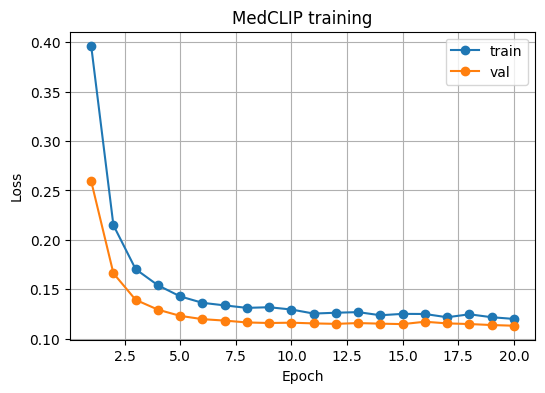

 New best val‑loss 0.1131 → saved medCLIP_runs_three2One/best‑epoch20.pth
[20/20]  train 0.1200 | val 0.1131 | 579.6s

 Best validation loss: 0.1131 (epoch 20)
 Best model saved to: medCLIP_runs_three2One/best_model.pth


In [ ]:
# Cell 13 — Main training loop with live plot 

os.environ["TOKENIZERS_PARALLELISM"] = "false"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

NUM_EPOCHS = 20
WCKPT_PATH  = SAVE_DIR / "checkpoint.pth"
BEST_PATH  = SAVE_DIR / "best_model.pth"

# ─── Resume if checkpoint exists ───────────────────────────────
start_epoch = 1
best_val, best_ep = float("inf"), 0
train_hist, val_hist = [], []
best_state = None

if WCKPT_PATH.exists():
    print(f" Resuming from checkpoint → {WCKPT_PATH}")
    ckpt = torch.load(WCKPT_PATH, map_location=DEVICE)

    model.load_state_dict(ckpt["model"])
    ema_model.load_state_dict(ckpt["ema_model"])
    optimizer.load_state_dict(ckpt["optimizer"])

    # default resume point
    start_epoch = ckpt["epoch"] + 1

    start_epoch = max(start_epoch, 8)

    best_val    = ckpt["best_val"]
    best_ep     = ckpt["best_ep"]
    best_state  = ckpt["best_state"]
    train_hist  = ckpt["train_hist"]
    val_hist    = ckpt["val_hist"]

print(f"Starting/continuing at epoch {start_epoch} / {NUM_EPOCHS}")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    t0          = time.time()
    train_loss  = run_one_epoch(train_loader, train=True)
    val_loss    = run_one_epoch(val_loader,   train=False)

    train_hist.append(train_loss)
    val_hist.append(val_loss)

    # ── live plot ────────────────────────────────────────────────
    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(range(1, epoch+1), train_hist, marker='o', label='train')
    plt.plot(range(1, epoch+1), val_hist,   marker='o', label='val')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MedCLIP training")
    plt.grid(True); plt.legend(); plt.show()

    # ── save best EMA weights ───────────────────────────────────
    if val_loss < best_val:
        best_val   = val_loss
        best_ep    = epoch
        best_state = deepcopy(ema_model.state_dict())
        fname      = os.path.join(SAVE_DIR, f"best‑epoch{epoch:02d}.pth")
        torch.save(best_state, fname)
        print(f" New best val‑loss {best_val:.4f} → saved {fname}")
    
    # ─ Save training checkpoint ─
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "ema_model": ema_model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "best_val": best_val,
        "best_ep": best_ep,
        "best_state": best_state,
        "train_hist": train_hist,
        "val_hist": val_hist,
    }, WCKPT_PATH)

    dt = time.time() - t0
    print(f"[{epoch:02d}/{NUM_EPOCHS}]  "
          f"train {train_loss:.4f} | val {val_loss:.4f} | {dt:.1f}s")

# ─ Final save of best weights ─
torch.save(best_state, BEST_PATH)
print(f"\n Best validation loss: {best_val:.4f} (epoch {best_ep})")
print(f" Best model saved to: {BEST_PATH}")


In [20]:
from pathlib import Path
import json, numpy as np, torch
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer

# ─────────── Config pulled from Cell 0 ────────────────────────────
MODEL_WEIGHTS = CKPT_PATH     
DESC_PATH     = DESC_JSON      
DEVICE        = DEVICE        
MAX_LEN       = 128
TOP_DISEASES  = 5
TOP_PHRASES   = 3 

In [21]:
# ─────────── Tokeniser & image transforms (same as training) ─────
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
img_tfms  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ─────────── Load model weights ──────────────────────────────────
model = MedCLIPCustom(proj_dim=256).to(DEVICE).eval()
model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location=DEVICE),
                      strict=False)


<All keys matched successfully>

In [ ]:
# %% Cell — evaluate_dataset
def evaluate_dataset(
    ckpt_path: str | Path,
    desc_json: str | Path,
    test_root : str | Path,
    batch_size: int = 8,
    max_len   : int = 128,
    topks     : tuple[int, ...] = (1, 3, 5, 10),
    device    : str | torch.device = DEVICE,
    phrase_weight: dict[tuple[str, str], float] | None = None,
):

    device = torch.device(device)

    # --- load JSON & label maps --------------------------------------------
    with open(desc_json, encoding="utf-8") as f:
        desc = json.load(f)

    diseases = sorted(desc)
    name2id  = {d: i for i, d in enumerate(diseases)}
    id2name  = {i: d for d, i in name2id.items()}

    # --- model --------------------------------------------------------------
    model = MedCLIPCustom(proj_dim=256).to(device).eval()
    model.load_state_dict(torch.load(ckpt_path, map_location=device),
                          strict=False)

    # --- embed every caption once ------------------------------------------
    phrase_embs, phrase_labels, phrase_wts = [], [], []
    tok = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

    with torch.no_grad():
        for disease, phrases in desc.items():
            d_key = disease.lower()
            for ph in phrases:
                enc  = tok(ph, padding="max_length", truncation=True,
                           max_length=max_len, return_tensors="pt")
                ids  = enc["input_ids"     ].unsqueeze(0).to(device)
                mask = enc["attention_mask"].unsqueeze(0).to(device)
                emb  = model.text_encoder(ids, mask).squeeze(0)   # (D,)
                phrase_embs.append(emb)
                phrase_labels.append(disease)

                # weight look‑up
                if phrase_weight is not None:
                    phrase_wts.append(phrase_weight.get((d_key, ph.strip()), 1.0))
                else:
                    phrase_wts.append(1.0)

    phrase_embs   = F.normalize(torch.stack(phrase_embs), dim=1)  # (T,D)
    phrase_labels = np.array(phrase_labels)
    phrase_wts    = torch.tensor(phrase_wts, device=device)

    # group caption indices per disease
    from collections import defaultdict
    class_idx, class_wt = defaultdict(list), defaultdict(list)
    for idx, lab in enumerate(phrase_labels):
        cid = name2id[lab]
        class_idx[cid].append(idx)
        class_wt [cid].append(float(phrase_wts[idx]))

    class_idx = {c: torch.tensor(ix, device=device) for c, ix in class_idx.items()}
    class_wt  = {c: torch.tensor(ws, device=device) for c, ws in class_wt.items()}

    print(f"Embedded {phrase_embs.size(0)} captions for {len(diseases)} diseases.")

    # --- helpers ------------------------------------------------------------
    def iter_test_images(root):
        for disease_dir in sorted(os.listdir(root)):
            cls_dir = Path(root) / disease_dir
            if not cls_dir.is_dir():
                continue
            for img_file in cls_dir.iterdir():
                if img_file.suffix.lower() not in {'.jpg', '.jpeg', '.png', '.bmp'}:
                    continue
                yield img_file, name2id[disease_dir]

    def batched(it, n):
        batch = []
        for x in it:
            batch.append(x)
            if len(batch) == n:
                yield batch
                batch = []
        if batch:
            yield batch

    # --- evaluation loop ----------------------------------------------------
    y_true, y_pred_top1, aps = [], [], []
    topk_hits = {k: 0 for k in topks}
    gamma = torch.exp(model.logit_scale)

    with torch.no_grad():
        for batch in tqdm(batched(iter_test_images(test_root), batch_size),
                          total=None, desc="eval"):
            paths, true_ids = zip(*batch)

            imgs = torch.stack([img_tfms(Image.open(p).convert("RGB"))
                                for p in paths]).to(device)
            img_emb = F.normalize(model.vision_encoder(imgs), dim=1)     # (B,D)

            sims = gamma * img_emb @ phrase_embs.T                       # (B,T)
            exp_sims = torch.exp(sims)

            # weighted caption pooling per disease
            class_scores = torch.zeros(img_emb.size(0), len(diseases), device=device)
            for cid, idxes in class_idx.items():
                w = class_wt[cid]
                w = w / w.sum()
                class_scores[:, cid] = (exp_sims[:, idxes] * w).sum(dim=1)

            # per‑sample metrics
            for i, t_id in enumerate(true_ids):
                y_true.append(t_id)
                sorted_ids = torch.argsort(class_scores[i], descending=True)

                rank = (sorted_ids == t_id).nonzero(as_tuple=True)[0].item()
                aps.append(1.0 / (rank + 1))

                y_pred_top1.append(sorted_ids[0].item())
                for k in topks:
                    if t_id in sorted_ids[:k]:
                        topk_hits[k] += 1

    # -------------------------- overall metrics -----------------------------
    from sklearn.metrics import precision_recall_fscore_support

    n_samples = len(y_true)
    topk_acc  = {k: topk_hits[k] / n_samples for k in topks}
    mAP       = float(np.mean(aps))

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, labels=list(range(len(diseases))),
        average="macro", zero_division=0
    )

    print("\n========== Evaluation ==========")
    for k, acc in topk_acc.items():
        print(f"Top-{k:<2} accuracy : {acc*100:.2f}%")
    print(f"Mean Average Precision: {mAP*100:.2f}%")
    print(f"Macro recall        : {recall*100:.2f}%")
    print(f"Macro F1            : {f1*100:.2f}%")

    return {
        **{f"top{k}_acc": acc for k, acc in topk_acc.items()},
        "mAP": mAP,
        "macro_precision": precision,
        "macro_recall"   : recall,
        "macro_f1"       : f1,
    }




In [ ]:

metrics = evaluate_dataset(
    ckpt_path=CKPT_PATH,
    desc_json=DESC_JSON,
    test_root=Few_TEST_ROOT,
    batch_size=16,
    phrase_weight=phrase_weight 
)

Embedded 400 captions for 40 diseases.


eval: 395it [01:00,  6.55it/s]


========== Evaluation ==========
Top-1  accuracy : 5.85%
Top-3  accuracy : 28.81%
Top-5  accuracy : 46.89%
Top-10 accuracy : 78.96%
Mean Average Precision: 25.34%
Macro recall        : 1.35%
Macro F1            : 2.30%


In [ ]:

metrics = evaluate_dataset(
    ckpt_path=CKPT_PATH,
    desc_json=DESC_JSON,
    test_root=Zero_TEST_ROOT,
    batch_size=16,
    phrase_weight=phrase_weight 
)

Embedded 400 captions for 40 diseases.


eval: 274it [00:43,  6.24it/s]


========== Evaluation ==========
Top-1  accuracy : 0.39%
Top-3  accuracy : 20.96%
Top-5  accuracy : 49.06%
Top-10 accuracy : 79.17%
Mean Average Precision: 20.10%
Macro recall        : 0.06%
Macro F1            : 0.12%
